# An Overview of Qiskit Nature
<br/>
<br/>
<br/>
<br/>
<br/>
Dariusz Lasecki<br/>
Max Rossmannek<br/>
IBM Quantum, IBM Research Europe - Zürich

Qiskit Nature is the application module dealing with problems in **natural sciences**.
Its goal is to provide end-user oriented modules which enable the fast solution of problems in _chemistry_, _physics_ and _biology_.

Chemistry problems are of particular interest because they are a natural simulation target for quantum computing.

<div style="float: left; width: 50%;">
    <br/>
    <br/>
    <i>"If you have 125 orbitals and you want to store all possible configurations, then you need more memory in your classical computer than there are atoms in the universe."</i>
    <br/>
    <br/>
    Matthias Troyer
    
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/intro.png" width="600"/>
    <br>
</div>

Nature currently provides the following modules:

<img src="images/overview.png" width="1400"/>

## Outline

| #  | Title                             | Time   |
|:--:|:----------------------------------|-------:|
| 1. | Electronic Structure Problems     | 30 min |
| 2. | Potential Energy Surface Sampling | 10 min |
| 3. | Protein Folding                   | 30 min |
|    |                                   |        |
|    |   Dep. on Time & Audience         |        |
| 4a)| Vibrational Structure Problems    | 10 min |
| 4b)| Excited States                    | 10 min |
|    |                                   |        |
| 5. | Q&A                               | 15 min |

In general, any application is split into **Problems** and **Solvers** which are combined like so:
<img src="images/Nature_YT_Workflow.svg"/>
> or in terms of code: `result = solver.solve(problem)`

This modular approach permits the reusability of a solver for multiple problems.

<div style="float: left; width: 51%;">
    Currently available <b>Problems</b> in Qiskit Nature:
</div>
<div style="float: right; width: 51%;">
    <img src="images/Nature_YT_Problems.svg" height="1900"/>
    <br>
</div>

<div style="float: left; width: 51%;">
    Currently available <b>Solvers</b> in Qiskit Nature:
</div>
<div style="float: right; width: 51%;">
    <img src="images/Nature_YT_Solvers.svg" height="1900"/>
    <br>
</div>

Depending on your actual application, the internals of your problem can take different forms.
For example, the `ElectronicStructureProblem` looks like this:
<img src="images/Nature_YT_ElectronicStructureProblem.svg"/>

A similar modularity exists for the solvers. Generally these are provided by the `qiskit_nature.algorihtms` module which provide convenient wrappers of the actual algorithms implemented in Qiskit Terra.
Here is an example of the `GroundStateEigensolver`:
<img src="images/Nature_YT_GroundStateEigensolver.svg"/>

In [1]:
import warnings

from h5py.h5py_warnings import H5pyDeprecationWarning
from sympy.utilities.exceptions import SymPyDeprecationWarning

warnings.filterwarnings(action="ignore", category=H5pyDeprecationWarning)
warnings.filterwarnings(action="ignore", category=SymPyDeprecationWarning)

## 1. Electronic Structure

See also: https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html

The `ElectronicStructureProblem` makes it easy for us to represent a problem in the second quantization form.
As an input, this kind of problem takes a so called `Driver` which is a concept in Qiskit Nature that allows us to couple to other (classical) computational chemistry codes which compute the 1- and 2-body integrals for us.

As a simple example, we will be using the generic `Molecule`-based interface and tell it to use `PySCF` as the classical computational backend.

In [2]:
from qiskit_nature.drivers import Molecule

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["Li", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, 1.6]],
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

In [3]:
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

We could now run the driver manually by calling `driver.run()` but the preferred way is to wrap it into the previously mentioned `ElectronicStructureProblem` which we can solve later on.

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver)

Out of curiosity let us inspect the Hamiltonian of our system in its second-quantized form:

In [5]:
# this will call driver.run() internally
second_q_ops = problem.second_q_ops()

In [6]:
from qiskit_nature.operators.second_quantization import FermionicOp

# we increase the truncation value of the FermionicOp applied while printing
FermionicOp.set_truncation(500)

In [7]:
hamiltonian = second_q_ops[0]
print(hamiltonian)

Fermionic Operator
register length=12, number terms=630
  (0.0011296372513031686+0j) * ( +_0 +_1 -_2 -_5 )
+ (-0.00535607625688124+0j) * ( +_0 -_1 +_2 -_5 )
+ (0.004226439005578081+0j) * ( +_0 -_1 -_2 +_5 )
+ (0.013337578188188285+0j) * ( +_0 -_1 +_6 -_7 )
+ (0.011215774496185733+0j) * ( +_0 -_1 +_6 -_8 )
+ (-0.008906674605061811+0j) * ( +_0 -_1 +_6 -_11 )
+ (-0.01333757818818827+0j) * ( +_0 -_1 -_6 +_7 )
+ (-0.011215774496185726+0j) * ( +_0 -_1 -_6 +_8 )
+ (0.008906674605061815+0j) * ( +_0 -_1 -_6 +_11 )
+ (-0.0033493907209032926+0j) * ( +_0 -_1 ...


We can gain further insight by investigating the raw output of our driver (see also: https://qiskit.org/documentation/nature/tutorials/08_property_framework.html):

In [8]:
print(problem.grouped_property)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=Li 0.0 0.0 0.0;H 0.0 0.0 1.6
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.991250528138408
		[0, 1] = -0.16708957810828062
		[0, 2] = -0.2100427441610491
		[0, 3] = -4.2195209411401814e-17
		[0, 4] = 1.7414817922089306e-17
		[0, 5] = 0.0934584980900287
		[1, 0] = 0.03270658526251444
		[1, 1] = 0.4552443615020863
		[1, 2] = 0.7995433555171316
		[1, 3] = 2.1215448445429555e-16
		[1, 4] = -7.161072791302347e-17
		[1, 5] = -0.7026838049076921
		[2, 0] = 3.5788462179277705e-18
		[2, 1] = -3.894665491717105e-17
		[2, 2] = 2.0351321811307387e-16
		[2, 3] = 0.3362049857205108
		[2, 4] = 0.9417888338564392
		[2, 5] = -1.9341387091246027e-17
		[3, 0] = 6.844624790828517e-20
		[3, 1] = 2.55

<div style="float: left; width: 50%;">
    We can reduce the size of our problem by selected a subset of orbitals to be treated with the quantum algorithm. This concept is known as an <b>active space</b>.
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/active_space.png" width="600"/>
</div>

Qiskit Nature provides the generic `ActiveSpaceTransformer` to apply such a reduction:

In [9]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3,
)

In [10]:
problem_reduced = ElectronicStructureProblem(driver, [transformer])
second_q_ops_reduced = problem_reduced.second_q_ops()
hamiltonian_reduced = second_q_ops_reduced[0]

In [11]:
print(hamiltonian_reduced)

Fermionic Operator
register length=6, number terms=61
  (0.013063981998616431+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.013063981998616449+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.04857959952039955+0j) * ( +_0 -_1 )
+ (0.005767502046078003+0j) * ( +_0 -_1 +_5 -_5 )
+ (0.007484171005652937+0j) * ( +_0 -_1 +_4 -_4 )
+ (-0.04857958891222261+0j) * ( +_0 -_1 +_3 -_3 )
+ (-0.013509390402447741+0j) * ( +_0 -_1 +_2 -_2 )
+ (0.02342267323977018+0j) * ( +_0 -_2 +_3 -_5 )
+ (-0.02342267323977018+0j) * ( +_0 -_2 -_3 +_5 )
+ (0.019276892448525745+0j) * ( +_0 -_2 +_4 -_5 )
+ (- ...


In [12]:
print(problem_reduced.grouped_property_transformed)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=Li 0.0 0.0 0.0;H 0.0 0.0 1.6
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9912505281384075
		[0, 1] = -0.16708957810821973
		[0, 2] = -0.21004274416109897
		[0, 3] = 6.7865900795003166e-18
		[0, 4] = -3.9975809971989005e-17
		[0, 5] = 0.09345849809003225
		[1, 0] = 0.03270658526251557
		[1, 1] = 0.45524436150186126
		[1, 2] = 0.7995433555172335
		[1, 3] = -2.790684679073614e-17
		[1, 4] = 9.419497461369897e-17
		[1, 5] = -0.7026838049077221
		[2, 0] = 2.162969091912887e-18
		[2, 1] = -1.754018724707431e-16
		[2, 2] = 4.343032256024671e-18
		[2, 3] = 0.8258346409356669
		[2, 4] = 0.5639123565153175
		[2, 5] = 1.5401694951912251e-16
		[3, 0] = -2.238331296185125e-19
		[3, 1] = 3.6

### Mapping the Problem to the Qubit Space

In order to solve our problem with a Quantum algorithm we must map our second-quantized Hamiltonian into a qubit operator. This is done with the `QubitConverter` in combination with a `QubitMapper` of your choice.

Each MO can hold up to two electrons, one spin-up (_alpha_) and one spin-down (_beta_) electron.

In Qiskit we will need to map these two cases onto the quantum computer separately. Thus, we are working with **spin orbitals** which are identical to the MOs but restrict the spin in either the up or down configuration, depending on the nature of the orbital.

The most straight forward mapping is the *Jordan-Wigner* one which stores the *occupation* information of one spin orbital in one qubit:

<img src="images/jw_mapping.png" width="1400"/>

In [13]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

jw_mapper = JordanWignerMapper()
jw_converter = QubitConverter(jw_mapper)

In [14]:
qubit_op_jw = jw_converter.convert(hamiltonian_reduced)
print(qubit_op_jw)

-0.46007433515282226 * IIIIII
- 0.16165347149873271 * ZIIIII
- 0.1457163212955356 * IZIIII
+ 0.06017866224139519 * ZZIIII
+ 0.02669401397935853 * IIZIII
+ 0.06168720475907442 * ZIZIII
+ 0.05263651528550084 * IZZIII
- 0.16165347149873266 * IIIZII
+ 0.0782363777898524 * ZIIZII
+ 0.07049783624066888 * IZIZII
+ 0.06754287306901696 * IIZZII
- 0.14571632129553552 * IIIIZI
+ 0.07049783624066888 * ZIIIZI
+ 0.08447056807294796 * IZIIZI
+ 0.05590251078515496 * IIZIZI
+ 0.06017866224139519 * IIIZZI
+ 0.026694013979358444 * IIIIIZ
+ 0.06754287306901696 * ZIIIIZ
+ 0.05590251078515496 * IZIIIZ
+ 0.12182774215821922 * IIZIIZ
+ 0.06168720475907442 * IIIZIZ
+ 0.05263651528550084 * IIIIZZ
+ 0.012080473194464935 * IXXIII
+ 0.0033773476006119358 * ZXXIII
+ 0.012080473194464935 * IYYIII
+ 0.0033773476006119358 * ZYYIII
- 0.0014418755115195008 * IXXZII
- 0.0014418755115195008 * IYYZII
- 0.0018710427514132375 * IXXIZI
- 0.0018710427514132375 * IYYIZI
+ 0.012144897228055652 * IXXIIZ
+ 0.012144897228055652 * I

In this step we can reduce the size of our problem further by leveraging symmetries in the Hilbert space of our system. One mapping which supports a straight-forward removal of 2 qubits by exploiting the particle-conserving properties of electronic structure problems, is the *parity* mapping:

In [15]:
from qiskit_nature.mappers.second_quantization import ParityMapper

parity_mapper = ParityMapper()
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

In [16]:
qubit_op_parity = parity_converter.convert(hamiltonian_reduced, num_particles=problem_reduced.num_particles)
print(qubit_op_parity)

-0.4600743351528221 * IIII
+ (-0.21428998678423353-1.3877787807814457e-17j) * ZIII
+ (0.03348464826203665+1.734723475976807e-18j) * IZII
- 0.20740352605460996 * ZZII
+ (0.21428998678423344+1.3877787807814457e-17j) * IIZI
- 0.07823637778985237 * ZIZI
+ 0.06754287306901693 * IZZI
- 0.07049783624066885 * ZZZI
+ (-0.03348464826203673-3.469446951953614e-18j) * IIIZ
+ 0.06754287306901693 * ZIIZ
- 0.12182774215821919 * IZIZ
+ 0.05590251078515494 * ZZIZ
+ (-0.20740352605460988-6.938893903907228e-18j) * IIZZ
+ 0.07049783624066885 * ZIZZ
+ (-0.05590251078515494-3.469446951953614e-18j) * IZZZ
+ 0.08447056807294794 * ZZZZ
+ 0.015457820795076866 * IXII
+ 0.015457820795076868 * ZXII
+ (0.0014418755115195004-1.0842021724855044e-19j) * IXZI
+ 0.0014418755115195004 * ZXZI
+ 0.012144897228055649 * IXIZ
+ (0.012144897228055649+8.673617379884035e-19j) * ZXIZ
- 0.001871042751413237 * IXZZ
- 0.001871042751413237 * ZXZZ
+ 0.0103191739992737 * XIXI
- 0.0103191739992737 * XZXI
+ 0.0103191739992737 * XIXZ
- 0.0

### Finding the Ground-State Solution

<div style="float: left; width: 50%;">
Now that we have converted our problem to a Qubit operator, we need to find it's eigenvalue which corresponds to the ground state of our system.
    <br/>
    <br/>
    See also: https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/H2_gs.png" width="400"/>
    <br>
</div>

To find the ground state we need an *Ansatz* to describe our wavefunction:

In [17]:
particle_number = problem_reduced.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles

In [18]:
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.circuit.library.ansatzes import UCCSD

init_state = HartreeFock(num_spin_orbitals, num_particles, parity_converter)

ansatz = UCCSD(
    parity_converter,
    num_particles,
    num_spin_orbitals,
)
ansatz.initial_state = init_state

ansatz.decompose().draw('mpl', style='iqx')

Since this is quite some overhead which even involves knowing the number of particles beforehand, we provide a **factory** for the `VQE`, simplifying its construction a lot:

In [19]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCFactory

# this will setup the UCCSD + HartreeFock Ansatz internally at runtime
vqe_factory = VQEUCCFactory(
    quantum_instance=StatevectorSimulator(),
    #quantum_instance=QasmSimulator(),
    optimizer=SLSQP(),
)

This factory can then be used to construct a `GroundStateEigensolver` with which we can finally solve our problem:

In [20]:
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

solver = GroundStateEigensolver(parity_converter, vqe_factory)

In [21]:
result = solver.solve(problem_reduced)

In [22]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.855126562263
  - computed part:      -1.058906993492
  - ActiveSpaceTransformer extracted energy part: -7.796219568771
~ Nuclear repulsion energy (Hartree): 0.992207270475
> Total ground state energy (Hartree): -7.862919291788
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.0235618]
 
  0: 
  * Electronic dipole moment (a.u.): [0.00000001  -0.00000003  4.90825173]
    - computed part:      [0.00000001  -0.00000003  4.91230364]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  -0.00405191]
  > Dipole moment (a.u.): [-0.00000001  0.00000003  -1.88468993]  Total: 1.88468993
                 (debye): [-0.00000003  0.00000007  -4.79040352]  Total: 4.79040352
 


#### VQE Runtime

See also: https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html

The newly introduced **Runtime** greatly reduces the waiting time associated with running quantum algorithms on real hardware devices. It does so by (among other things) executing the classical parts of a hybrid quantum-classical algorithm on an IBM server closely located to the actual device, thereby minimizing communication overhead.

<div style="float: left; width: 50%;">
    <b>Before:</b>
    <img src="images/runtime_1.png" width="800"/>
    <b>Now:</b>
    <img src="images/runtime_2.png" width="800"/>
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <br/>
    <br/>
    <br/>
    <br/>
    <img src="images/runtime_3.png" width="800"/>
</div>

In [23]:
from urllib3.connection import SystemTimeWarning
warnings.filterwarnings(action="ignore", category=SystemTimeWarning)

In [24]:
import numpy as np

np.random.seed(42)

We can load our IBMQ account, the provider and select a backend which has runtime-support:

In [25]:
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(group="open")
print("Provider supports runtime: ", provider.has_service("runtime"))

backend = provider.get_backend("ibmq_qasm_simulator")

Provider supports runtime:  True


We prepare our previously constructed `UCC` Ansatz for the Runtime architecture (which only supports certain basis gates):

In [26]:
from qiskit import transpile

basis_gates = ["rx", "ry", "rz", "sx", "cx"]
transpiled_ansatz = transpile(ansatz, basis_gates=basis_gates, optimization_level=0)

And finally we can construct a new VQE solver using `VQEProgram`:

In [27]:
optimizer = {
    "name": "SPSA",
    "maxiter": 50,
}
initial_point = np.zeros(ansatz.num_parameters)

In [28]:
from qiskit_nature.runtime import VQEProgram  # will soon be renamed to VQEClient

runtime_vqe = VQEProgram(
    ansatz=transpiled_ansatz,
    optimizer=optimizer,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)

In [29]:
runtime_vqe_solver = GroundStateEigensolver(parity_converter, runtime_vqe)

In [30]:
runtime_result = runtime_vqe_solver.solve(problem_reduced)

In [31]:
print(runtime_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.850783950811
  - computed part:      -1.05456438204
  - ActiveSpaceTransformer extracted energy part: -7.796219568771
~ Nuclear repulsion energy (Hartree): 0.992207270475
> Total ground state energy (Hartree): -7.858576680336
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.018 S^2: 0.019 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.0235618]
 
  0: 
  * Electronic dipole moment (a.u.): [-0.01633792  0.39779219  4.77096457]
    - computed part:      [-0.01633792  0.39779219  4.77501649]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  -0.00405191]
  > Dipole moment (a.u.): [0.01633792  -0.39779219  -1.74740277]  Total: 1.79218359
                 (debye): [0.04152686  -1.01108681  -4.44145441]  Total: 4.55527587
 


## 2. Potential Energy Surface Sampling

See also: https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html

Sampling the PES of a system can be easily done by defining **degrees of freedom** on the `Molecule`:

In [32]:
from functools import partial

stretch = partial(Molecule.absolute_distance, atom_pair=(0, 1))

dof_molecule = Molecule(
    geometry=[
        ["Li", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, 1.6]],
    ],
    degrees_of_freedom=[stretch],
)

In [33]:
dof_driver = ElectronicStructureMoleculeDriver(
    molecule=dof_molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

In [34]:
dof_problem = ElectronicStructureProblem(dof_driver, [transformer])

We can now use this opportunity to compare the results produced by various solvers:

In [35]:
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import COBYLA

variants = {
    "numpy": {
        "solver": NumPyMinimumEigensolver(filter_criterion=dof_problem.get_default_filter_criterion()),
        "bootstrap": False,
    },
    "statevector": {
        "solver": VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=50), quantum_instance=StatevectorSimulator()),
        "bootstrap": False
    },
    "qasm": {
        "solver": VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=50), quantum_instance=QasmSimulator(shots=2048)),
        "bootstrap": False,
    },
    "qasm+bootstrap": {
        "solver": VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=50), quantum_instance=QasmSimulator(shots=2048)),
        "bootstrap": True,
    },
}

After setting the points at which to sample the PES...

In [36]:
points = np.linspace(0.5, 3.0, 25)

...we can use the `BOPESSampler` to do the heavy lifting for us:

In [37]:
from qiskit_nature.algorithms.pes_samplers import BOPESSampler

results = {}

# this code will take a while...
for label, setup in variants.items():
    bs = BOPESSampler(
        gss=GroundStateEigensolver(parity_converter, setup["solver"]),
        bootstrap=setup["bootstrap"],
        num_bootstrap=None,
        extrapolator=None,
    )
    
    res = bs.sample(dof_problem, points)
    
    results[label] = {
        "points": res.points,
        "energies": res.energies,
    }

And finally we can plot our results:

/home/oss/Files/PhD/workshops/EQTC2021/workshop/.direnv/python-3.9.7/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Energy [Ha]')

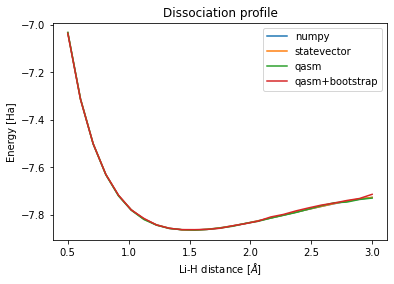

In [38]:
from matplotlib import pyplot as plt

fig = plt.figure()
for label, values in results.items():
    plt.plot(
        values["points"],
        values["energies"],
        label=label,
    )
plt.legend()
plt.title("Dissociation profile")
plt.xlabel(r"Li-H distance [$\AA$]")
plt.ylabel("Energy [Ha]")

## 3. Protein Folding

Presented by Dariusz Lasecki

## 4. Additional Topic

### a) Vibrational Structure

Taking a closer look at another `Problem` provided by Qiskit Nature.

### b) Excited States

Taking a closer look at another `Solver` provided by Qiskit Nature.

## 4a) Vibrational Structure

See also: https://qiskit.org/documentation/nature/tutorials/02_vibrational_structure.html

Besides *electronic structure* calculations another important problem to solve is the **vibrational** structure of a molecule. For this, Qiskit Nature leverages `Gaussian` as a classical backend.

I prepared a `VibrationalStructureProblem` prior to this tutorial using the `GaussianForcesDriver` like so:
```python
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization.gaussiand import (
    GaussianForcesDriver,
    GaussianLogDriver,
)

molecule = Molecule(
    geometry=[
        ["Li", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, 1.6]],
    ],
    multiplicity=1,
    charge=0,
)

driver = GaussianForcesDriver.from_molecule(molecule, basis="sto3g")

log_driver = GaussianLogDriver(jcf=driver._jcf)
log_result = log_driver.run()

print("\n".join(log_result._log))
```

We can now load that precomputed result like so:

In [39]:
from qiskit_nature.drivers.second_quantization.gaussiand import GaussianForcesDriver

driver = GaussianForcesDriver(logfile="aux_files/log.txt")

And wrap it into our usual stack of a `VibrationalStructureProblem`:

In [40]:
from qiskit_nature.problems.second_quantization.vibrational import VibrationalStructureProblem

vib_problem = VibrationalStructureProblem(driver, num_modals=2, truncation_order=2)

We can also construct a `GroundStateEigensolver` with a mapper applicable to the vibrational structure problem:

In [41]:
from qiskit_nature.mappers.second_quantization import DirectMapper

vib_converter = QubitConverter(DirectMapper())

In [42]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory

vib_numpy_solver = GroundStateEigensolver(
    vib_converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)
)

In [43]:
vib_result = vib_numpy_solver.solve(vib_problem)

The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!
The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!


In [44]:
print(vib_result)

=== GROUND STATE ENERGY ===
 
* Vibrational ground state energy (cm^-1): (775.988907300138+0j)
The number of occupied modals is
- Mode 0: [1.0000000000000002]


## 4b) Excited States of Electronic + Vibrational Structures

See also: https://qiskit.org/documentation/nature/tutorials/04_excited_states_solvers.html

Now, we are not only interested in ground states but also excited states! `QEOM` provides the means to compute these states by solving the **equation of motion**.

In [45]:
from qiskit_nature.algorithms.excited_states_solvers import QEOM

# QEOM currently does not support the 2-qubit reduction which we used in combination with the parity mapping.
# Thus, we use the Jordan-Wigner mapping here.
jw_solver = GroundStateEigensolver(jw_converter, vqe_factory)

# Notice how QEOM takes a `GtoundStateEigensolver` as an input (because it starts off from a ground state)
qeom = QEOM(jw_solver, "sd")

In [46]:
qeom_result = qeom.solve(problem_reduced)

In [47]:
print(qeom_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.855126562232
  - computed part:      -1.058906993461
  - ActiveSpaceTransformer extracted energy part: -7.796219568771
~ Nuclear repulsion energy (Hartree): 0.992207270475
> Total ground state energy (Hartree): -7.862919291757
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): (-8.714203520568+0j)
* Electronic excited state energy (Hartree): -8.714203520568
> Total excited state energy (Hartree): -7.721996250093
  2: 
* Electronic excited state energy (Hartree): (-8.670464968481+0j)
* Electronic excited state energy (Hartree): -8.670464968481
> Total excited state energy (Hartree): -7.678257698006
  3: 
* Electronic excited state energy (Hartree): (-8.669758823692+0j)
* Electronic excited state energy (Hartree): -8.669758823692
> Total excited state energy (Hartree): -7.677551553217
  4: 
* Electronic excited state energy (Hartree): (-8.612408186735+0j)
* Electronic excited s

/home/oss/Files/PhD/workshops/EQTC2021/workshop/.direnv/python-3.9.7/lib64/python3.9/site-packages/qiskit_nature/results/electronic_structure_result.py:324: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  "* Electronic excited state energy (Hartree): {}".format(round(elec_energy, 12))


You can also evaluate auxiliary operators on excited states with the `NumPyEigensolver` (which is a classical algorithm to solve the EOM).

In [48]:
from qiskit_nature.algorithms.excited_states_solvers.eigensolver_factories import NumPyEigensolverFactory

numpy_es_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)

This solver can simply be wrapped into an `ExcitedStatesEigensolver`, mirroring the interface of the `GroundStateEigensolver`:

In [49]:
from qiskit_nature.algorithms.excited_states_solvers import ExcitedStatesEigensolver

es_solver = ExcitedStatesEigensolver(parity_converter, numpy_es_solver)

In [50]:
numpy_es_result = es_solver.solve(problem_reduced)

In [51]:
print(numpy_es_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.855126607118
  - computed part:      -1.058907038347
  - ActiveSpaceTransformer extracted energy part: -7.796219568771
~ Nuclear repulsion energy (Hartree): 0.992207270475
> Total ground state energy (Hartree): -7.862919336643
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): (-8.70073766237+0j)
* Electronic excited state energy (Hartree): -8.70073766237
> Total excited state energy (Hartree): -7.708530391895
  2: 
* Electronic excited state energy (Hartree): (-8.640017417721+0j)
* Electronic excited state energy (Hartree): -8.640017417721
> Total excited state energy (Hartree): -7.647810147246
  3: 
* Electronic excited state energy (Hartree): (-8.220429676058+0j)
* Electronic excited state energy (Hartree): -8.220429676058
> Total excited state energy (Hartree): -7.228222405583
  4: 
* Electronic excited state energy (Hartree): (-8.170038706484+0j)
* Electronic excited sta

Comparing the previous result with that of the `QEOM` algorithm we notice that some excited states are missing which have a different spin than the ground state. To remedy that we can use a non-default filter criterion which only asserts the number of particles (and not the total spin):

In [52]:
def filter_criterion(eigenstate, eigenvalue, aux_values):
    # we only ensure that the number of particles equals 2
    return np.isclose(aux_values[0][0], 2.)

new_numpy_es_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)

new_numpy_es_calculation = ExcitedStatesEigensolver(parity_converter, new_numpy_es_solver)

In [53]:
new_numpy_es_result = new_numpy_es_calculation.solve(problem_reduced)

In [54]:
print(new_numpy_es_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.855126607118
  - computed part:      -1.058907038347
  - ActiveSpaceTransformer extracted energy part: -7.796219568771
~ Nuclear repulsion energy (Hartree): 0.992207270475
> Total ground state energy (Hartree): -7.862919336643
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): (-8.714194770362+0j)
* Electronic excited state energy (Hartree): -8.714194770362
> Total excited state energy (Hartree): -7.721987499887
  2: 
* Electronic excited state energy (Hartree): (-8.70073766237+0j)
* Electronic excited state energy (Hartree): -8.70073766237
> Total excited state energy (Hartree): -7.708530391895
  3: 
* Electronic excited state energy (Hartree): (-8.67800525899+0j)
* Electronic excited state energy (Hartree): -8.67800525899
> Total excited state energy (Hartree): -7.685797988515
  4: 
* Electronic excited state energy (Hartree): (-8.640017417721+0j)
* Electronic excited state

Let us now turn towards excited states of **vibrational** structure problems. We can use `QEOM` in the same style as we did before:

In [55]:
vib_qeom = QEOM(vib_numpy_solver, "sd")

In [56]:
vib_qeom_result = vib_qeom.solve(vib_problem)

The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!
The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!
The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!
The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!


In [57]:
print(vib_qeom_result)
print("\nExcited State Energies:", vib_qeom_result.computed_vibrational_energies[1:])

=== GROUND STATE ENERGY ===
 
* Vibrational ground state energy (cm^-1): (775.988907300138+0j)
The number of occupied modals is
- Mode 0: [1.0000000000000002]

Excited State Energies: [2395.4869927+0.j]


We can also use the `ExcitedStatesEigensolver` with the classical numpy-based eigensolver in this scenario:

In [58]:
vib_es_solver = ExcitedStatesEigensolver(vib_converter, numpy_es_solver)

In [59]:
vib_np_result = vib_es_solver.solve(vib_problem)

The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!
The original qubit operator only contains 2 qubits! Skipping the requested two-qubit reduction!


In [60]:
print(vib_np_result)
print("\nExcited State Energies:", vib_np_result.computed_vibrational_energies[1:])

=== GROUND STATE ENERGY ===
 
* Vibrational ground state energy (cm^-1): (775.988907300138+0j)
The number of occupied modals is
- Mode 0: [1.0000000000000002]
- Mode 1: [0.9999999999999999]

Excited State Energies: [2395.4869927+0.j]


## Additional Resources

* Documentation: https://qiskit.org/documentation/nature/
* Tutorials: https://qiskit.org/documentation/nature/tutorials/index.html
* Source code: https://github.com/Qiskit/qiskit-nature

In [61]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/home/oss/Files/PhD/workshops/EQTC2021/workshop/.direnv/python-3.9.7/lib64/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
